# Supervised topic-modeling
## A proof of concept

<br>

### Marco Repetto $^1$ $^2$
#### University of Milano-Bicocca, <br> Milan 22 Apr. 2020

<br>

$^1$ Data scientist @ Siemens Digital Industries <br>
$^2$ PhD candidate in Economics and Statistics @ University Milan-Bicocca <br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-proof-of-concept" data-toc-modified-id="A-proof-of-concept-1">A proof of concept</a></span><ul class="toc-item"><li><span><a href="#Marco-Repetto-$^1$-$^2$" data-toc-modified-id="Marco-Repetto-$^1$-$^2$-1.1">Marco Repetto $^1$ $^2$</a></span><ul class="toc-item"><li><span><a href="#University-of-Milano-Bicocca,--Milan-22-Apr.-2020" data-toc-modified-id="University-of-Milano-Bicocca,--Milan-22-Apr.-2020-1.1.1">University of Milano-Bicocca, <br> Milan 22 Apr. 2020</a></span></li></ul></li></ul></li><li><span><a href="#Required-ingredients" data-toc-modified-id="Required-ingredients-2">Required ingredients</a></span></li><li><span><a href="#The-contribute" data-toc-modified-id="The-contribute-3">The contribute</a></span></li><li><span><a href="#The-notation" data-toc-modified-id="The-notation-4">The notation</a></span></li><li><span><a href="#Model-specification" data-toc-modified-id="Model-specification-5">Model specification</a></span><ul class="toc-item"><li><span><a href="#Model-objective" data-toc-modified-id="Model-objective-5.1">Model objective</a></span></li><li><span><a href="#Step-1:-how-to-estimate-$S$?" data-toc-modified-id="Step-1:-how-to-estimate-$S$?-5.2">Step 1: how to estimate $S$?</a></span></li><li><span><a href="#Step-2:-how-to-estimate-$O$?" data-toc-modified-id="Step-2:-how-to-estimate-$O$?-5.3">Step 2: how to estimate $O$?</a></span></li><li><span><a href="#Step-3:-how-do-we-predict?" data-toc-modified-id="Step-3:-how-do-we-predict?-5.4">Step 3: how do we predict?</a></span></li></ul></li><li><span><a href="#Use-case-Dante" data-toc-modified-id="Use-case-Dante-6">Use case Dante</a></span><ul class="toc-item"><li><span><a href="#The-three-Dantes" data-toc-modified-id="The-three-Dantes-6.1">The three Dantes</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-7">Modelling</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Feature-selection" data-toc-modified-id="Step-1:-Feature-selection-7.1">Step 1: Feature selection</a></span></li><li><span><a href="#Step-2:-Topic-modelling" data-toc-modified-id="Step-2:-Topic-modelling-7.2">Step 2: Topic modelling</a></span></li><li><span><a href="#Step-3:-Scoring-on-webpage" data-toc-modified-id="Step-3:-Scoring-on-webpage-7.3">Step 3: Scoring on webpage</a></span></li><li><span><a href="#Wait-a-minute..." data-toc-modified-id="Wait-a-minute...-7.4">Wait a minute...</a></span></li></ul></li><li><span><a href="#Let's-do-some-real-machine-learning" data-toc-modified-id="Let's-do-some-real-machine-learning-8">Let's do some real machine learning</a></span></li><li><span><a href="#Can-we-use-verses-instead-of-cantos?" data-toc-modified-id="Can-we-use-verses-instead-of-cantos?-9">Can we use verses instead of cantos?</a></span></li><li><span><a href="#Can-we-use-this-model-even-further?" data-toc-modified-id="Can-we-use-this-model-even-further?-10">Can we use this model even further?</a></span></li><li><span><a href="#Use-case-Smart-Scouting" data-toc-modified-id="Use-case-Smart-Scouting-11">Use case Smart Scouting</a></span></li><li><span><a href="#Data-gathering-process" data-toc-modified-id="Data-gathering-process-12">Data gathering process</a></span></li><li><span><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-13">Exploratory analysis</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-keywords-by-customer-and-prospect" data-toc-modified-id="Distribution-of-keywords-by-customer-and-prospect-13.1">Distribution of keywords by customer and prospect</a></span></li><li><span><a href="#Let's-normalize:-stemming" data-toc-modified-id="Let's-normalize:-stemming-13.2">Let's normalize: stemming</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-14">Modelling</a></span><ul class="toc-item"><li><span><a href="#Why-are-we-predicting-on-test-data?" data-toc-modified-id="Why-are-we-predicting-on-test-data?-14.1">Why are we predicting on test data?</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-15">References</a></span></li></ul></div>

## Required ingredients

In [1]:
import beautifultools as bt
import pandas as pd
import wordcloud as wc
import pickle
#import qgrid
import os.path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## The contribute
This notebook applies the approach originally stated by <cite data-cite="4251771/LA4VJEQV"></cite> into two very different use cases, namely:

1. Find whether a bunch of text belongs to Dante's Inferno; and
2. Given a series of prospects web-pages find the ones more similar to actual customers.

# The framework
The **source of variation exploited** by the framework is given by the signals contained inside a text corpora.

For example two different authors may have different ways of writing the same piece of text, the aim is capture this signals in a bag-of-words fashion.  

The **commonsense** suggests that this is possible however a rigorous model is required.

## The notation
The notation used in the model formulation is:
* $n$: number of text corpus;
* $m$: number of words;
* $d_i \in \mathbb{R}^m_+$: word counts of the ith corpus;
* $D$: the matrix containing all the corpus array $d$ such that: 

$$D = [d_1,...,d_n]'$$

* $S$: is the set indexing a subset of sentiment charged words such that $D_{.,[S]} \subset D$;
* $y_i$: particular label associated to the i*th* corpus;
* $p_i$: corpus sentiment such that $p_i \in [0,1]$;
* $O_+$ and $O_-$ the distribution of positive and negative sentiment words.

## Model specification
In the model **conditional independence** is assumed between $d_i$ and $y_i$ given $p_i$.

An additional assumption is that **conditional distribution**, namely:

$$\mathbb{P}(\text{sign}(y_i)=1)=g(p_i)$$

where $g(\cdot)$ is required to be **monotonically increasing**.

Last, we assume the dictionary of words $\{1,2,...,m\}$ to be composed as such $S \cup N$ namely that each word can be sentiment changing or sentiment neutral. More importantly $d_{i,[S]}$ and $d_{i,[N]}$ are assumed to be **independent**.

Moreover, is assumed that "sentiment-charged" word counts follow a **mixture multinomial model** as:

$$d_{i,[S]} \sim \text{Multinomial}(s_i, p_i O_+ + (1-p_i) O_-)$$

### Model objective

Objective of the model: learn $O_+$, $O_-$, $p_i$.

The steps:
1. Isolating the set of most relevant sentiment words from all the articles, $S$;
2. Assign term-specific sentiment weights based on their relevance in prediction, estimating the parameters $O_+$, $O_-$; and
3. Estimate the article-level sentiment $p_i$.

### Step 1: how to estimate $S$?
We can use the following regression setting:

$$
\text{sgn}(y_i) = f_j \cdot \text{sgn}(d_{i,j}) + \epsilon_i
 \quad j =  1...m$$

Then for the selection of the sentiment charged words we can identify the following thresholds: $(\alpha_+,\alpha_-,\kappa)$.

The result is therefore: 

$$
\hat{S} = \left\{j: f_j \geq \frac{1}{2} + \alpha_+ \right\} \cup \left\{j: f_j \leq \frac{1}{2} - \alpha_-\right\} \cap \left\{j: \kappa_j \geq \kappa\right\}
$$

### Step 2: how to estimate $O$?
Generally in **topic modeling** is used a **non-supervised** approach because labels are not observable. However in our use cases we **observe labels** making the problem a **supervised** one. 

That gives an advantage in terms of **convergence** to the true sentiment value **<cite data-cite="4251771/JVGVKGPH"></cite>**.

The **two topics modeling** is performed using the following regression setting:

$$
\mathbb{E}\tilde{D}' = OW
$$

Where:
* $\tilde{D}$ is the set of all sentiment charged word frequencies per corpus;
* $O$ is the matrix containing positive an negative words $[O_+, O_-]$;
* $W$ is the matrix containing all the sentiment score for each word.

Since both $\tilde{D}$ and $W$ are not observed we can use **sample estimates**. The **in sample sentiment score** can be set as:

$$\hat{p_i} = \frac{\text{rank of } y_i \text{ in } \{y_l\}^n_{l=1}}{n}$$


### Step 3: how do we predict?
Predicting on new text corpus means finding a $p_i$ for a new corpus fed into the pipeline.

The estimation was carried out using **maximum likelihood estimation** in the following fashion:

$$ \hat{p} = \text{arg} \max_{p\in[0,1]} \left\{ \hat{s}^{-1} \sum^{\hat{s}}_{j=1} d_j \log \left(p\hat{O}_{+,j} + (1-p)\hat{O}_{-,j} \right) + \lambda \log(p(1-p)) \right\}$$

The role of the penalty is to help cope with the **limited number of observations** and the **low signal-to-noise ratio**, basically pushes $\hat{p}$ toward $0.5$

## Use case Dante
Find out which verses belong to Dante's Inferno.

In [6]:
%ls

LICENSE             __pycache__/        data/               model/
README.md           beautifultools.py   img/                web-scraping.ipynb


In [18]:
path = './data/dante.txt'
granularity = "canto"
clean=True


import string
from io import StringIO
import nltk
from nltk.corpus import stopwords

if path == "":
    # Get the repository containing the relevant text
    url = "https://raw.githubusercontent.com/dlang/druntime/master/benchmark/extra-files/dante.txt"

    # Request the raw .txt and decode it
    response = requests.get(url)
    dante = response.text
else:
    f = open(path)
    dante = f.read()
    
# String processing starts here
# Make string lowercase
dante = dante.lower()

# Remove headings
dante = dante.replace(
    "la divina commedia\ndi dante alighieri\n\n\n\n\n\ninferno\n\n\n\n\n", ""
)
dante = dante.replace("\n\n\n\n\n\npurgatorio\n", "")
dante = dante.replace("\n\n\n\n\n\nparadiso\n", "")

# Punctation and other amenities removal
dante = dante.translate(
    str.maketrans(
        {i: "" for i in string.punctuation + "”" + "“" + "»" + "«" + "‘"}
    )
)

dante = dante.translate(str.maketrans({i: " " for i in "’" + "—"}))

# Make string  csv-like
if granularity == "verso":
    dante = (
        dante.replace("\n\n\n", ",")
        .replace(",\n", ";")
        .replace("\n\n", "\n")
        .replace("\n", ":")
        .replace(";", "\n")
        .replace(" · ", ",")
    )
elif granularity == "terzina":
    dante = (
        dante.replace("\n\n\n", ",")
        .replace(",\n", ";")
        .replace("\n\n", ":")
        .replace("\n", " ")
        .replace(";", "\n")
        .replace(" · ", ",")
    )
else:
    dante = (
        dante.replace("\n\n\n", ",")
        .replace(",\n", ";")
        .replace("\n\n", " ")
        .replace("\n", " ")
        .replace(";", "\n")
        .replace(" · ", ",")
    )

# Create the dataframe
dante = pd.read_csv(
    StringIO(dante),
    header=None,
    names=["label", "canto", "content"],
    index_col=[0, 1],
)


if granularity != "canto":
    # Augment granulairity of the df splitting verses
    dante = dante.content.str.split(":", expand=True)

    # Rename splitted columns to apply wide_to_long
    dante = dante.rename(
        {i: "content" + str(i) for i in dante.columns if str(i).isnumeric()},
        axis=1,
    )

    # Apply wide to long need to reset index for reindexing
    dante = dante.reset_index()
    dante = pd.wide_to_long(
        dante, stubnames="content", i=["label", "canto"], j=granularity
    )

    # drop na and empty strings
    dante = dante[dante["content"].astype(bool)]

if clean:
    # Remove italian stopwords
    dante.loc[:, "content"] = dante.loc[:, "content"].apply(
        lambda x: " ".join(
            [
                w
                for w in nltk.word_tokenize(x)
                if not w in stopwords.words("italian") and len(w) > 2
            ]
        )
    )

dante

content
label    canto                                                          
inferno  canto i       mezzo cammin vita ritrovai selva oscura ché di...
         canto ii      giorno andava aere bruno toglieva animai terra...
         canto iii     città dolente etterno dolore perduta gente giu...
         canto iv      ruppemi alto sonno testa greve truono riscossi...
         canto v       così discesi cerchio primaio giù secondo men l...
...                                                                  ...
paradiso canto xxix    quando ambedue figli latona coperti montone li...
         canto xxx     forse semilia miglia lontano ferve ora sesta m...
         canto xxxi    forma dunque candida rosa mostrava milizia san...
         canto xxxii   affetto piacer quel contemplante libero offici...
         canto xxxiii  vergine madre figlia figlio umile alta creatur...

[100 rows x 1 columns]

In [19]:
# Get data from Github and store it in a DataFrame
#df = bt.testData.dante(granularity="canto", clean=True)

df = dante

# Visualize it nicely
#qgrid.show_grid(df, show_toolbar=True)

### The three Dantes

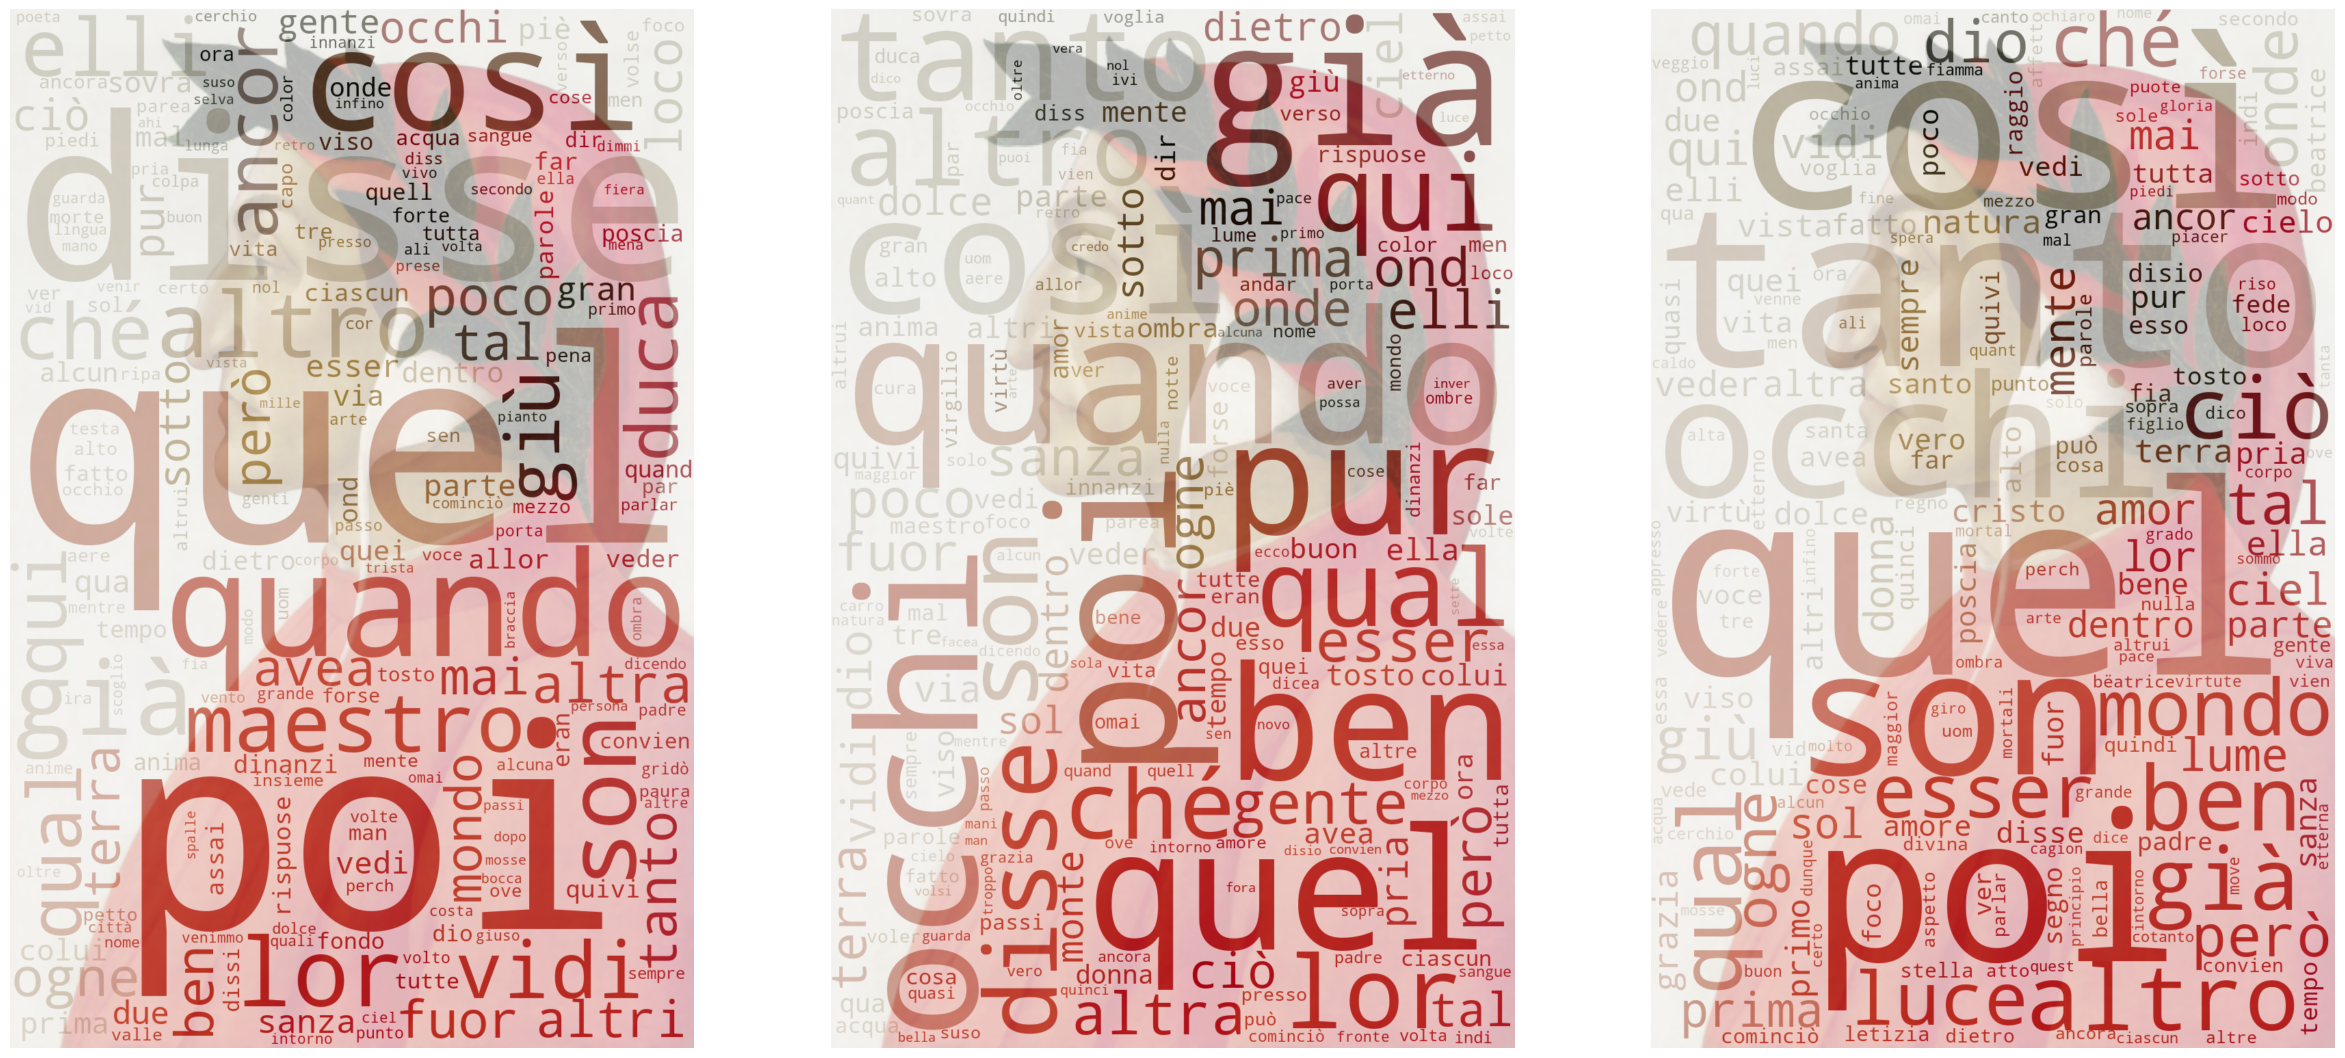

In [20]:
bt.word_cloud([
    " ".join(df.loc[i]["content"].tolist())
    for i in ["inferno", "purgatorio", "paradiso"]
],
              maskPath="img/Portrait_de_Dante.jpg",
              figsize=(30, 20))

## Modelling

In [21]:
# No need for multi index here
df = df.reset_index()

# No need for canto or verse label, we train on inferno purgatorio and paradiso
df = df.drop(["canto"], axis=1)

# Labelling, set inferno = 1, purgatorio and paradiso = 0
df["label"] = (df["label"] == "inferno").apply(lambda x: float(x))

#qgrid.show_grid(df, show_toolbar=True)

In [22]:
# Train model
res = bt.SSESTM(alpha_minus=0.5, alpha_plus=0.5, kappa=3).fit(X=df["content"],
                                                              y=df["label"])

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

### Step 1: Feature selection

In [ ]:
# Plot results from marginal screening, step 1
#qgrid.show_grid(res.marginal_screening)

### Step 2: Topic modelling

In [ ]:
# Creates the topic matrix containing the sentiment information of each sentiment charged word
topicMatrix = pd.DataFrame({
    "S": res.marginal_screening["term"],
    "Op": res.topic_coefficients[:, 0],
    "Om": res.topic_coefficients[:, 1]
})

#qgrid.show_grid(topicMatrix)

### Step 3: Scoring on webpage

In [ ]:
# Do predict
df["pred"] = res.predict(df["content"])

#qgrid.show_grid(df, show_toolbar=True)

### Wait a minute...
![](img/meme_test_data.png)

## Let's do some real machine learning

In [ ]:
# Do train and test split
df_train, df_test = train_test_split(df, test_size=0.07, random_state=1994)

In [ ]:
# Check if model exist and load/evaluate it
if os.path.isfile("model/dante_model.pickle"):
    print("Loading model")
    optModel = pickle.load(open("model/dante_model.pickle", 'rb'))

else:
    print("Evaluating model")
    parameters = {
        "kappa": (2, 4, 8, 16),
        "alpha_plus": (0.5, 0.6, 0.7, 0.8),
        "alpha_minus": (0.5, 0.4, 0.3, 0.2),
        "l": (0, 0.2, 0.4, 0.6)
    }

    # Do grid search hyper-parameter tuning with 5-fold cross-validation scoring on MSE
    clf = GridSearchCV(bt.SSESTM(),
                       parameters,
                       n_jobs=3,
                       scoring="neg_mean_squared_error",
                       cv=5,
                       iid=True,
                       verbose=5)  # Set verbose to maximum

    clf.fit(X=df_train["content"], y=df_train["label"])
    
    # Save this model
    pickle.dump(clf.best_estimator_, open("model/dante_model.pickle", "wb"))
    
    optModel = clf.best_estimator_

In [ ]:
# look what is inside it
optModel

In [ ]:
# Train model with best parameters
res = optModel.fit(X = df_train["content"], 
                              y = df_train["label"])

# Create an ad-hoc prediction column
df_test = df_test.copy()
df_test["pred"] = res.predict(df_test["content"])

#qgrid.show_grid(df_test)

## Can we use verses instead of cantos?

In [ ]:
verses = ["Così scendemmo ne la quarta lacca, pigliando più de la dolente ripa che ’l mal de l’universo tutto insacca.",
          "Così tornavan per lo cerchio tetro da ogne mano a l’opposito punto, gridandosi anche loro ontoso metro;",
          "dissi: «Maestro mio, or mi dimostra chegente è questa, e se tutti fuor cherci questi chercuti a la sinistra nostra».",
          "a poco a poco al mio veder si stinse: per che tornar con li occhi a Bëatrice nulla vedere e amor mi costrinse.",
          "O isplendor di Dio, per cu’ io vidi l’alto trïunfo del regno verace, dammi virtù a dir com’ ïo il vidi!",
          "Lume è là sù che visibile face lo creatore a quella creatura che solo in lui vedere ha la sua pace."]

test = pd.DataFrame({"verses": verses})

# Clean verses to be processed into the model
test["verses"] = test["verses"].apply(bt.verses_cleaner)

# Create an ad-hoc prediction column
test = test.copy()
test["pred"] = res.predict(test["verses"])

#qgrid.show_grid(test)

## Can we use this model even further?

In [ ]:
verses = ["Lo mio maestro mi disse di scendere per la aspra strada in fiamme, ma vidi la luce e l'amore della mia amata beatrice"]

test = pd.DataFrame({"verses": verses})

# Clean verses to be processed into the model
test["verses"] = test["verses"].apply(bt.verses_cleaner)

# Create an ad-hoc prediction column
test = test.copy()
test["pred"] = res.predict(test["verses"])

#qgrid.show_grid(test)

## Use case Smart Scouting
Use the information contained in the home pages of Siemens customers and potential ones to train an algorithm that outputs a sentiment $p = [0,1]$ on new potential prospects home pages.

## Data gathering process

In [ ]:
# Save/load the file based on its existence
if os.path.isfile("data/webpageTokens.pickle"):
    print("Loading file")
    with open("data/webpageTokens.pickle", "rb") as fp:  # UnPickling
        df = pickle.load(fp)

else:
    # Parse data from spreadsheets
    prospect = pd.read_excel("data/prospectRanking.xlsx")

    client = pd.read_excel("data/masterTemplate.xlsx",
                           sheet_name="Master Template")

    # Evaluate 2018-2017-2016 mean orders
    client["Orders Mean"] = client[[
        "Orders 18 DF_PD (cubo vs P.IVA) ",
        "Orders 17 DF_PD (cubo vs P.IVA)",
        "Orders 16 DF_PD (cubo vs P.IVA)",
    ]].mean(axis=1)
    # Reject rows if mean is 0 or below 0
    client = client[client["Orders Mean"] > 0]

    col1 = [0 for i in range(0, len(prospect["Sito Web"]))]
    col2 = list(prospect["Sito Web"])
    col3 = [0 for i in range(0, len(prospect["Sito Web"]))]

    col1.extend([1 for i in range(0, len(client["Sito Web"]))])
    col2.extend(list(client["Sito Web"]))
    col3.extend(list(client["Orders Mean"]))

    # Construct the dataframe and drop the NAs (no webpage exists)
    df = pd.DataFrame(({
        "Client": col1,
        "WebPage": col2,
        "Keywords": "",
        "Orders": col3
    }))
    df = df.dropna()
    
    # Check whether url exists and then get the data from the HTML file
    df = df.copy()
    df.loc[:, ("WebPage")] = df["WebPage"].apply(bt.urlize_string,
                                                 warning=False,
                                                 verify=False)
    df = df.dropna()
    df.loc[:, ("Keywords")] = df["WebPage"].apply(bt.webpage_text_tokenizer,
                                                  body=False,
                                                  verify=False)

    # Make df anonymous by stripping web-link
    df = df.drop(["WebPage"],axis=1)
    
    print("Saving file")
    with open("data/webpageTokens.pickle", "wb") as fp:  # Pickling
        pickle.dump(df, fp)

In [ ]:
# Get rid of duplicated keywords
df.loc[:, ("Keywords")] = df["Keywords"].apply(bt.drop_duplicates)

# Get rid of gone or forbidden pages
df = df[df.loc[:, ("Keywords")] != "gone"]
df = df[df.loc[:, ("Keywords")] != "forbidden"]
df = df[df.loc[:, ("Keywords")] != "home"]

# Get rid of home in description
df["Keywords"] = df["Keywords"].str.replace("home", "")

# Get rid of very short phrases
df = df[df["Keywords"].str.len() > 100]

In [ ]:
# A glimpse
#qgrid.show_grid(df)

## Exploratory analysis 
### Distribution of keywords by customer and prospect

In [ ]:
clientKeywords = " ".join(df["Keywords"][df["Client"] == 1].tolist())
prospectKeywords = " ".join(df["Keywords"][df["Client"] == 0].tolist())

In [ ]:
# Clients wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(clientKeywords).to_image()

In [ ]:
# Prospect wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(prospectKeywords).to_image()

### Let's normalize: stemming

In [ ]:
# Count number of unique words without stemming
keywordsNoStem = " ".join(df["Keywords"].tolist())
keywordsNoStem = bt.drop_duplicates(keywordsNoStem).split(" ")
len(keywordsNoStem)

In [ ]:
# Count number of unique words with stemming
keywordsStem = " ".join(df["Keywords"].tolist())
keywordsStem = bt.stem_words(keywordsStem)
keywordsStem = bt.drop_duplicates(keywordsStem).split(" ")
len(keywordsStem)

In [ ]:
# Apply stemming to words in the dataset
df["Keywords"] = df["Keywords"].apply(bt.stem_words)

## Modelling

In [ ]:
# Check if model exist and load/evaluate it
if os.path.isfile("model/prospect_model.pickle"):
    print("Loading model")
    optModel = pickle.load(open("model/prospect_model.pickle", 'rb'))

else:
    print("Evaluating model")
    parameters = {
        "kappa": (2, 4, 8, 16),
        "alpha_plus": (0.5, 0.6, 0.7, 0.8),
        "alpha_minus": (0.5, 0.4, 0.3, 0.2),
        "l": (0, 0.2, 0.4, 0.6)
    }
    
    # Do grid search hyper-parameter tuning with 5-fold cross-validation scoring on MSE
    clf = GridSearchCV(bt.SSESTM(),
                       parameters,
                       n_jobs=3,
                       scoring="neg_median_absolute_error",
                       cv=5,
                       iid=True,
                       verbose=5)

    clf.fit(X=df["Keywords"], y=df["Client"])

    pickle.dump(clf.best_estimator_, open("model/prospect_model.pickle", "wb"))

    optModel = clf.best_estimator_

In [ ]:
optModel

In [ ]:
# Train model with best parameters
res = optModel.fit(X=df["Keywords"], y=df["Client"])

# Create dataframe with only prospects
dfProspect = df[df["Client"] == 0]
dfProspect = dfProspect.drop(["Client", "Orders"], axis=1)

# Create an ad-hoc prediction column
dfProspect = dfProspect.copy()
dfProspect["pred"] = res.predict(dfProspect["Keywords"])

#qgrid.show_grid(dfProspect)

### Why are we predicting on test data?
Because in this case we say to have a **partial unlabeled** problem, since we observe clients label but for prospects the label is in fact misleading. For an overview of the problem is worth considering the survey of Bekker et al. <cite data-cite="4251771/AT6JW2CC"></cite>.

## References
<div class="cite2c-biblio"></div>